Dimensionality Reduction
---
##### 14Dec2018
Using discrete (`inputs/GSM1626793_P14Retina_1.digital_expression.txt.gz`, Mocosko, _et al_ 2015) and continuous (`inputs/qi_s1_edited_all.csv.gz`) datasets, downsample and feature select, then perform various DR techniques and compare the following:
* __Euclidean cell-cell distance__ correlations before and after transformation/reduction
* __Kullback-Leibler Divergence (KLD)__ explaining the Shannon entropy of the difference between the cumulative probability distributions of unique, normalized cell-cell distances.
* __K-nearest neighbor (Knn)__ preservation

In [1]:
import sys
from fcc_DRs import *
from fcc_utils import *

Using TensorFlow backend.


In [ ]:
# reload functions when editing file
del sys.modules['fcc_DRs']
from fcc_DRs import *

---
#### 0. read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [2]:
P14Retina = RNA_counts.from_file('inputs/GSM1626793_P14Retina_1.digital_expression.txt.gz', cells_axis=1, labels=[0,0])

In [3]:
P14Retina.data.shape

(6600, 20478)

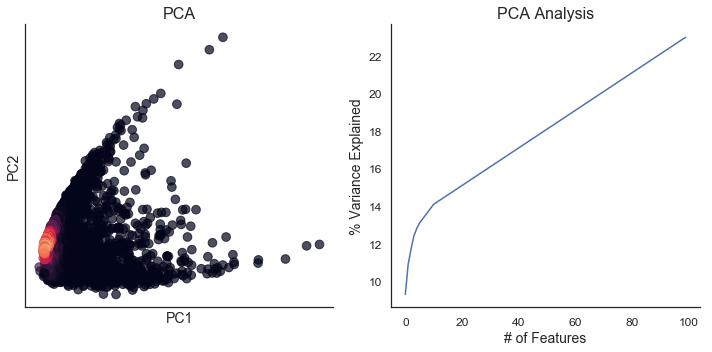

In [4]:
P14Retina_PCA100 = fcc_PCA(P14Retina.arcsinh_norm(), n_components=100)
P14Retina_PCA100.plot()

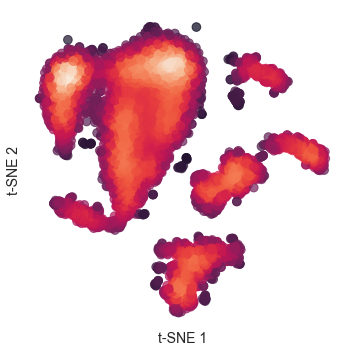

CPU times: user 58.1 s, sys: 2.36 s, total: 1min
Wall time: 1min 1s


In [5]:
%%time 
P14Retina_tSNE = fcc_tSNE(P14Retina_PCA100.results, perplexity=30) # use standard perplexity of 30 here
P14Retina_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x131ac8b38>)

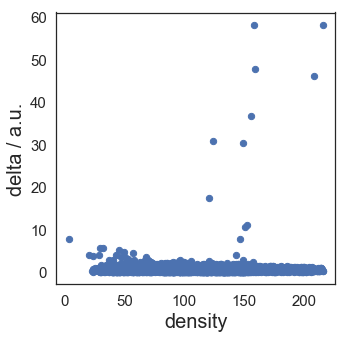

In [6]:
P14Retina_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x130e09080>)

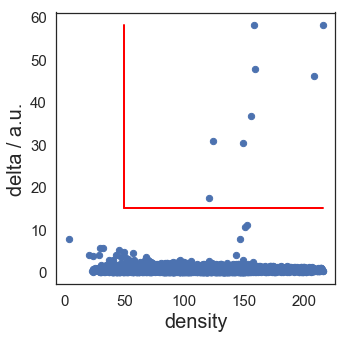

In [7]:
P14Retina_tSNE.clu.assign(50,15) # assign cluster center cutoffs
P14Retina_tSNE.clu.draw_decision_graph(min_delta=P14Retina_tSNE.clu.min_delta, min_density=P14Retina_tSNE.clu.min_density) # plot chosen density-peak cluster centers

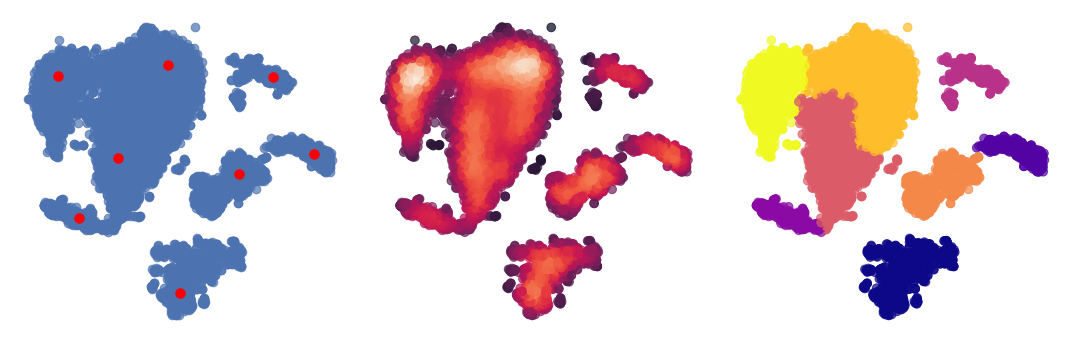

In [8]:
P14Retina_tSNE.plot_clusters() # visualize clustering

In [9]:
print('Silhouette Score: {}\n'.format(P14Retina_tSNE.silhouette_score))
P14Retina_tSNE.cluster_counts()

Silhouette Score: 0.4709610939025879

892 cells in cluster 0 (13.515 %)

384 cells in cluster 1 (5.818 %)

309 cells in cluster 2 (4.682 %)

363 cells in cluster 3 (5.5 %)

1325 cells in cluster 4 (20.076 %)

674 cells in cluster 5 (10.212 %)

1696 cells in cluster 6 (25.697 %)

957 cells in cluster 7 (14.5 %)



---
#### 1. subsample discrete dataset and perform DRs
* select _500 most variable genes_
* downsample to _1000 cells_ with _proportional representation from prior clustering_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_

In [10]:
# select 500 most variable genes
P14Retina_varselect = RNA_counts.var_select(P14Retina, n_features=500) 

In [11]:
# choose 1000 cells with proportional representation from clusters above
P14Retina_0 = RNA_counts.downsample_proportional(P14Retina_varselect, P14Retina_tSNE.clu.membership, n_cells=1000, seed=10)

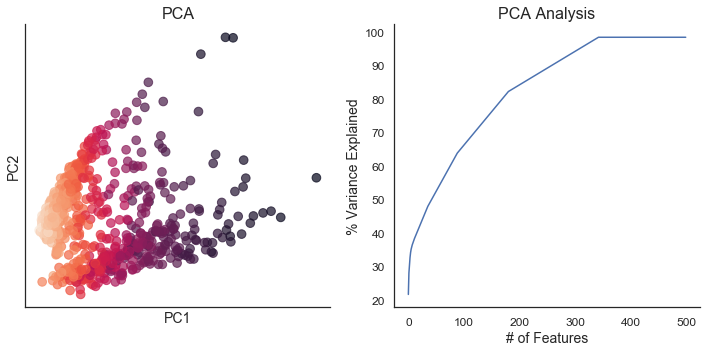

In [12]:
P14Retina_0_PCA500 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=500) # 500 component PCA as control
P14Retina_0_PCA500.plot()

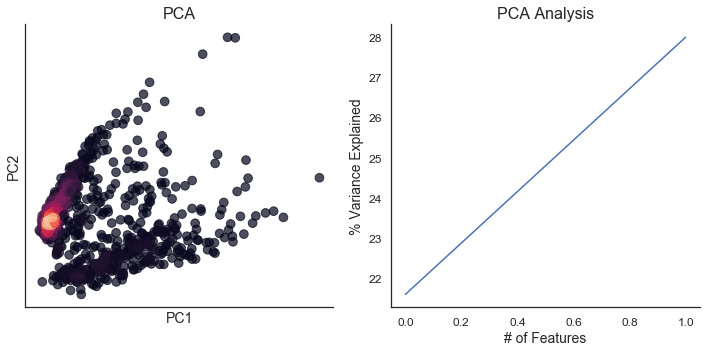

In [13]:
P14Retina_0_PCA2 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=2) # 2 component PCA
P14Retina_0_PCA2.plot()

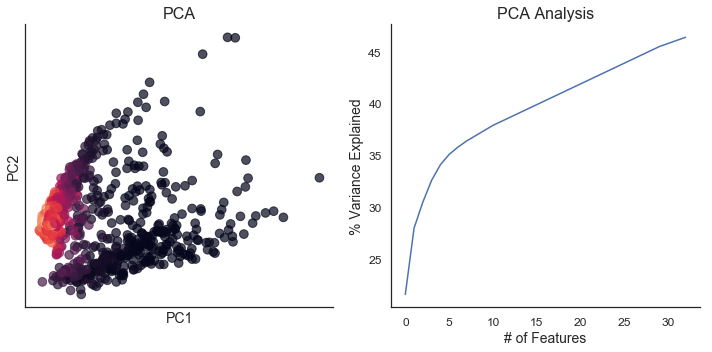

In [23]:
P14Retina_0_PCA33 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=33) # 33 component PCA
P14Retina_0_PCA33.plot()

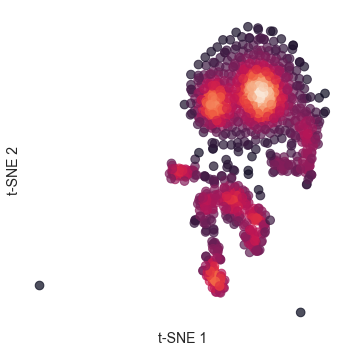

In [14]:
P14Retina_0_tSNE = fcc_tSNE(P14Retina_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_tSNE.plot()

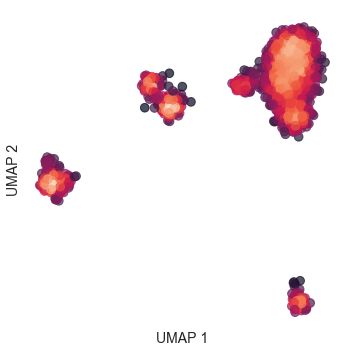

In [15]:
P14Retina_0_UMAP = fcc_UMAP(P14Retina_0.arcsinh_norm(), perplexity=30) # UMAP with perplexity 30
P14Retina_0_UMAP.plot()

In [16]:
P14Retina_0_DCA = fcc_DCA(P14Retina_0.counts, norm=False) # DCA on raw counts

DCA: Successfully preprocessed 500 genes and 1005 cells.
Calculating low dimensional representations...
Calculating reconstructions...


---
#### 2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

In [17]:
k = 30 # choose value for K-nearest neighbor calculations

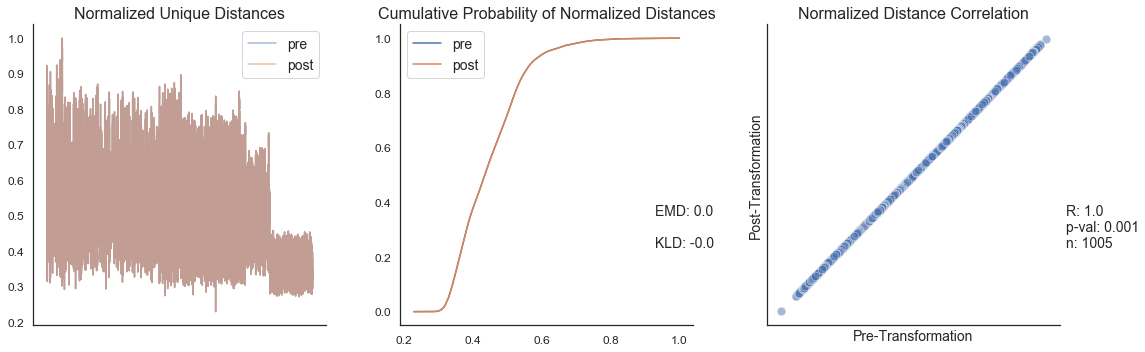

Knn Preservation: 100.0

CPU times: user 30.3 s, sys: 4.21 s, total: 34.5 s
Wall time: 34.2 s


In [18]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA500.knn_graph(k))))

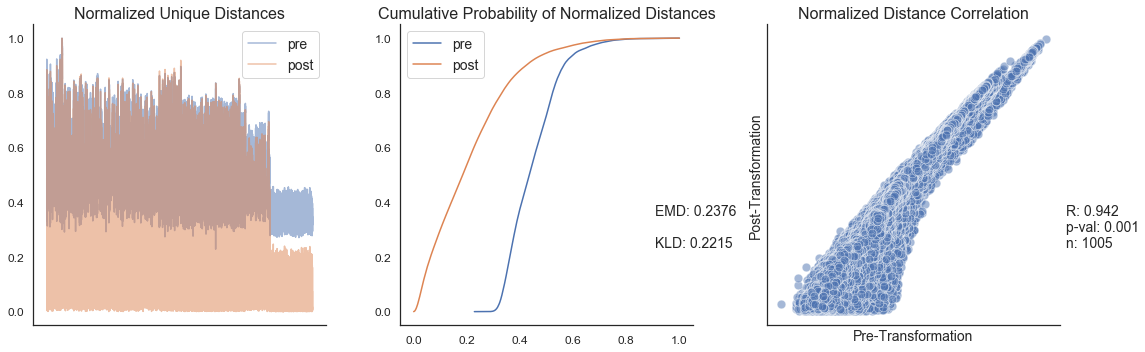

Knn Preservation: 96.9668

CPU times: user 30.2 s, sys: 4.03 s, total: 34.3 s
Wall time: 41.3 s


In [19]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA2.knn_graph(k))))

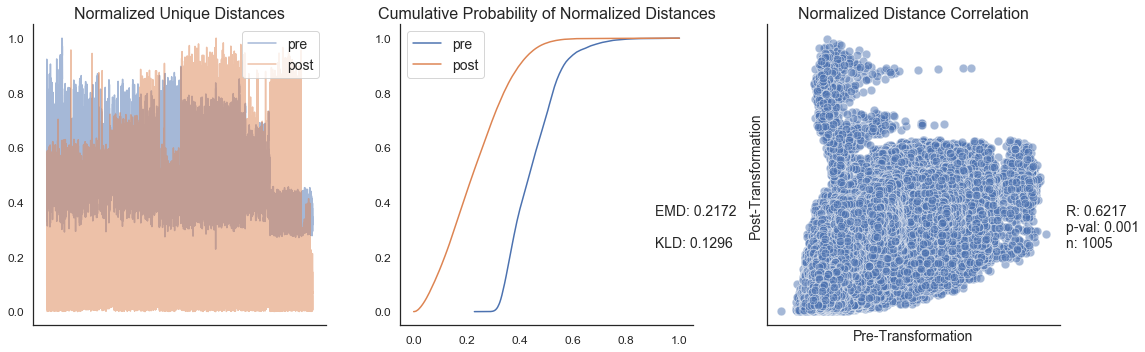

Knn Preservation: 95.7815

CPU times: user 29.4 s, sys: 4.11 s, total: 33.5 s
Wall time: 33.3 s


In [20]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_tSNE.knn_graph(k))))

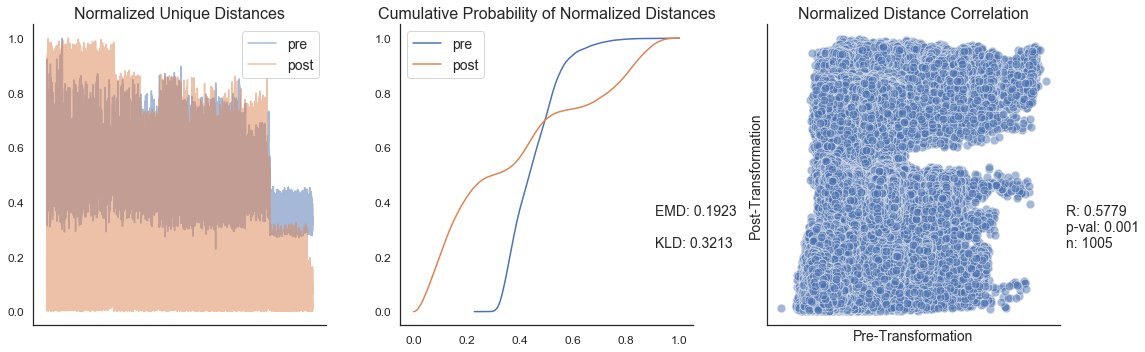

Knn Preservation: 94.9742

CPU times: user 27.1 s, sys: 4.13 s, total: 31.3 s
Wall time: 30.7 s


In [21]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_UMAP.knn_graph(k))))

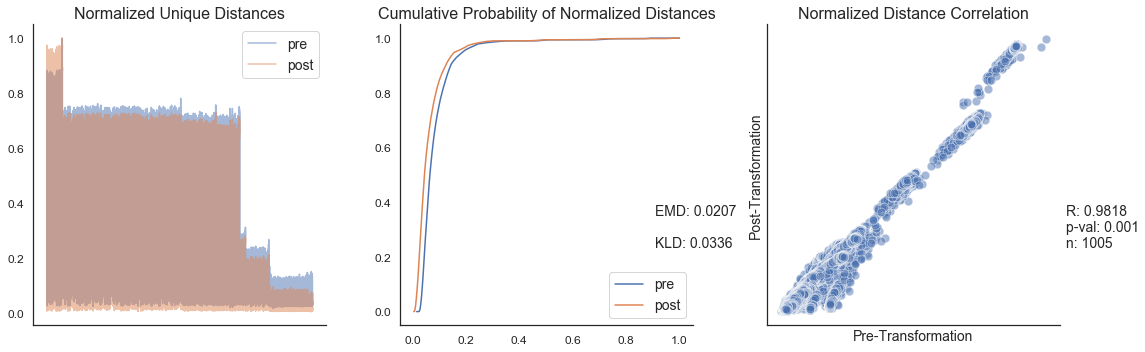

Knn Preservation: 96.5205

CPU times: user 30.6 s, sys: 4.47 s, total: 35.1 s
Wall time: 35 s


In [22]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0_DCA.knn_graph(k))))

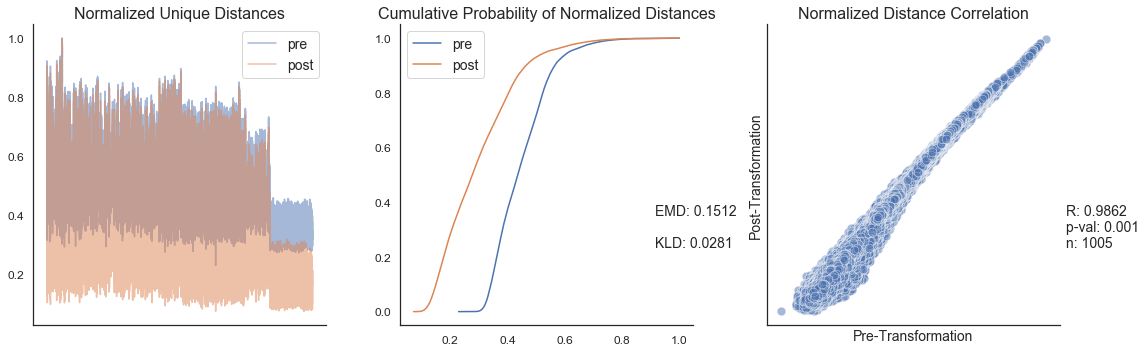

Knn Preservation: 97.9945

CPU times: user 27.2 s, sys: 3.33 s, total: 30.5 s
Wall time: 29.9 s


In [24]:
%%time
# look at 33-component PCA vs 500-feature dataset to compare to DCA
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA33.knn_graph(k))))

---
#### 3. repeat for continuous dataset

---
#### 3.0. read in continuous dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [25]:
%time qi = RNA_counts.from_file('inputs/qi_s1_edited_all.csv.gz', cells_axis=0, labels=[None,None])

CPU times: user 15.8 s, sys: 892 ms, total: 16.7 s
Wall time: 16.9 s


In [26]:
qi.data.shape

(1595, 25507)

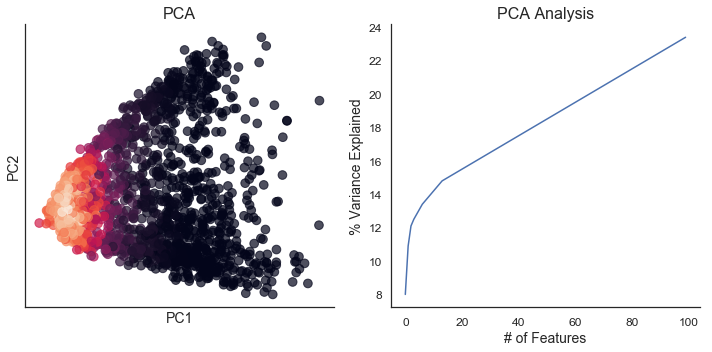

In [27]:
qi_PCA100 = fcc_PCA(qi.arcsinh_norm(), n_components=100)
qi_PCA100.plot()

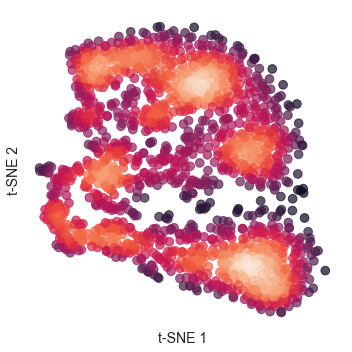

CPU times: user 11.3 s, sys: 423 ms, total: 11.8 s
Wall time: 11.6 s


In [28]:
%%time 
qi_tSNE = fcc_tSNE(qi_PCA100.results, perplexity=30) # use standard perplexity of 30 here
qi_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12d349e48>)

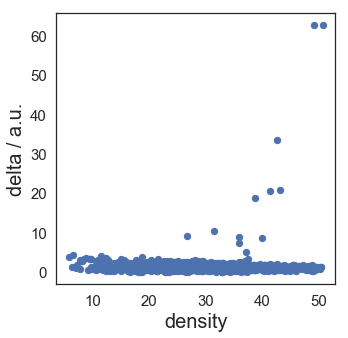

In [29]:
qi_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x127e5ff60>)

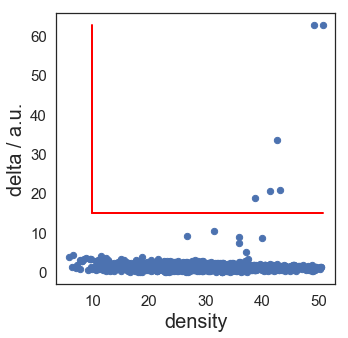

In [30]:
qi_tSNE.clu.assign(10,15) # assign cluster center cutoffs
qi_tSNE.clu.draw_decision_graph(min_delta=qi_tSNE.clu.min_delta, min_density=qi_tSNE.clu.min_density) # plot chosen density-peak cluster centers

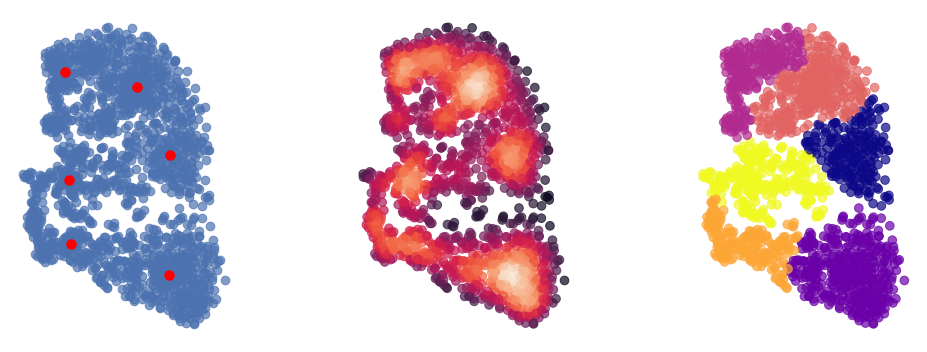

In [31]:
qi_tSNE.plot_clusters() # visualize clustering

In [32]:
print('Silhouette Score: {}\n'.format(qi_tSNE.silhouette_score))
qi_tSNE.cluster_counts()

Silhouette Score: 0.40152332186698914

214 cells in cluster 0 (13.417 %)

382 cells in cluster 1 (23.95 %)

231 cells in cluster 2 (14.483 %)

308 cells in cluster 3 (19.31 %)

200 cells in cluster 4 (12.539 %)

260 cells in cluster 5 (16.301 %)



---
#### 3.1. feature-select continuous dataset and perform DRs
* select _500 most variable genes_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_

In [33]:
# select 500 most variable genes
qi_0 = RNA_counts.var_select(qi, n_features=500) 

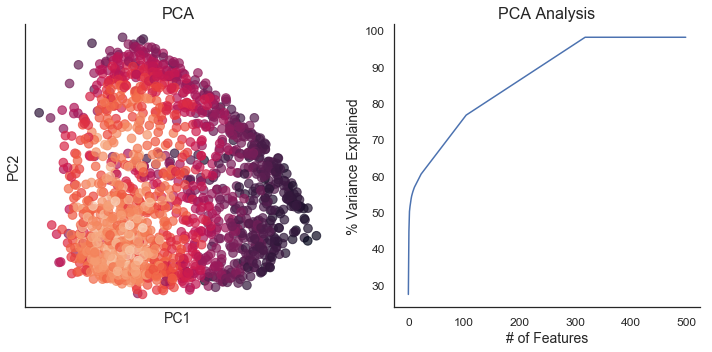

In [34]:
qi_0_PCA500 = fcc_PCA(qi_0.arcsinh_norm(), n_components=500) # 500 component PCA as control
qi_0_PCA500.plot()

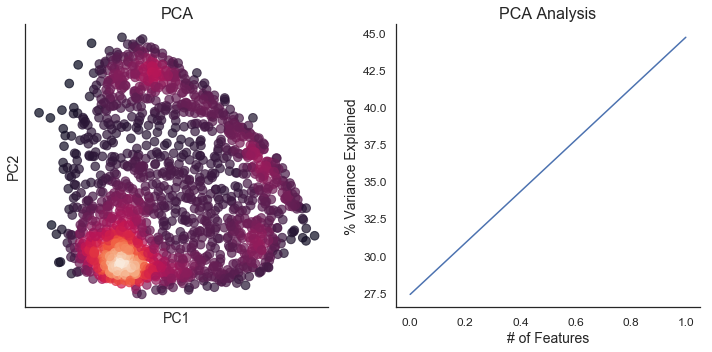

In [35]:
qi_0_PCA2 = fcc_PCA(qi_0.arcsinh_norm(), n_components=2) # 2 component PCA
qi_0_PCA2.plot()

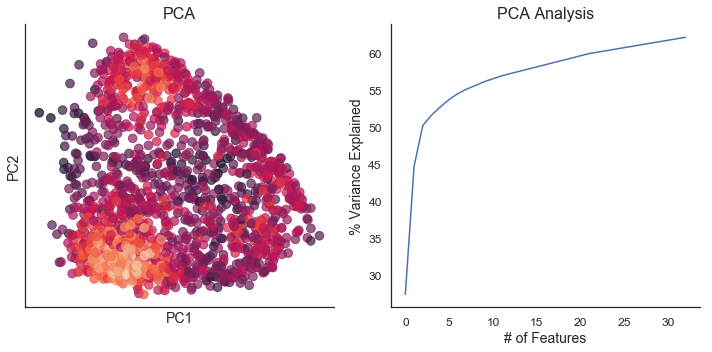

In [36]:
qi_0_PCA33 = fcc_PCA(qi_0.arcsinh_norm(), n_components=33) # 33 component PCA to compare to DCA
qi_0_PCA33.plot()

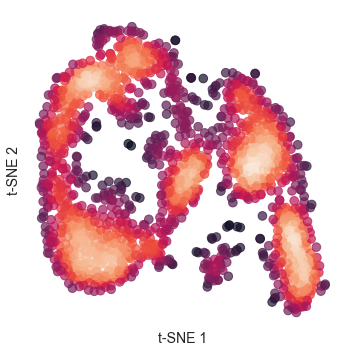

In [37]:
qi_0_tSNE = fcc_tSNE(qi_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
qi_0_tSNE.plot()

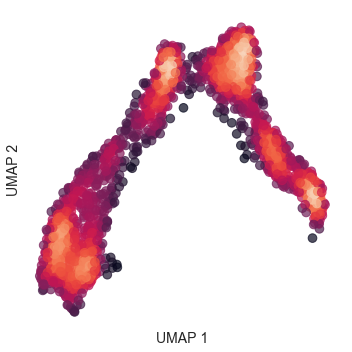

In [38]:
qi_0_UMAP = fcc_UMAP(qi_0.arcsinh_norm(), perplexity=30) # UMAP with perplexity 30
qi_0_UMAP.plot()

In [39]:
qi_0_DCA = fcc_DCA(qi_0.counts, norm=False) # DCA on raw counts

DCA: Successfully preprocessed 500 genes and 1595 cells.
Calculating low dimensional representations...
Calculating reconstructions...


---
#### 3.2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

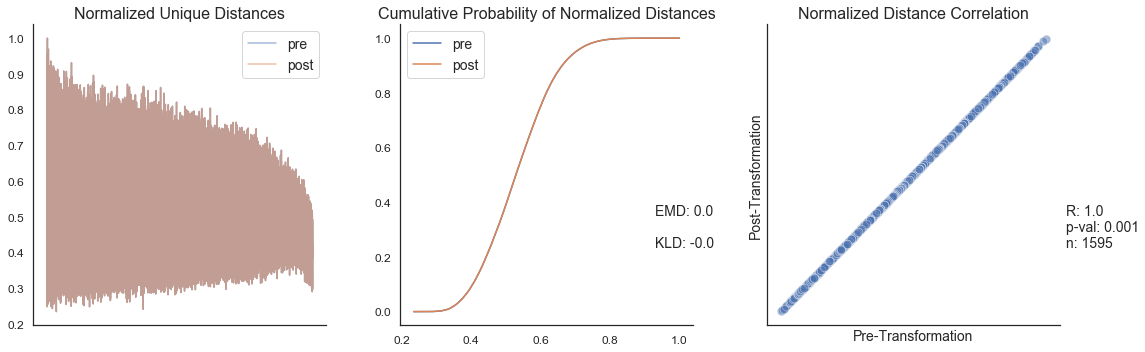

Knn Preservation: 100.0

CPU times: user 1min 26s, sys: 13.6 s, total: 1min 39s
Wall time: 1min 39s


In [40]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA500.knn_graph(k))))

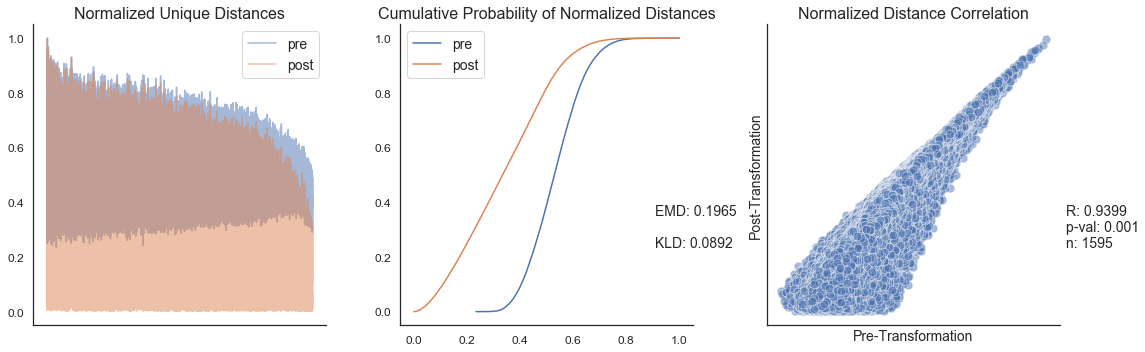

Knn Preservation: 98.6186

CPU times: user 1min 18s, sys: 12.8 s, total: 1min 31s
Wall time: 1min 31s


In [41]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA2.knn_graph(k))))

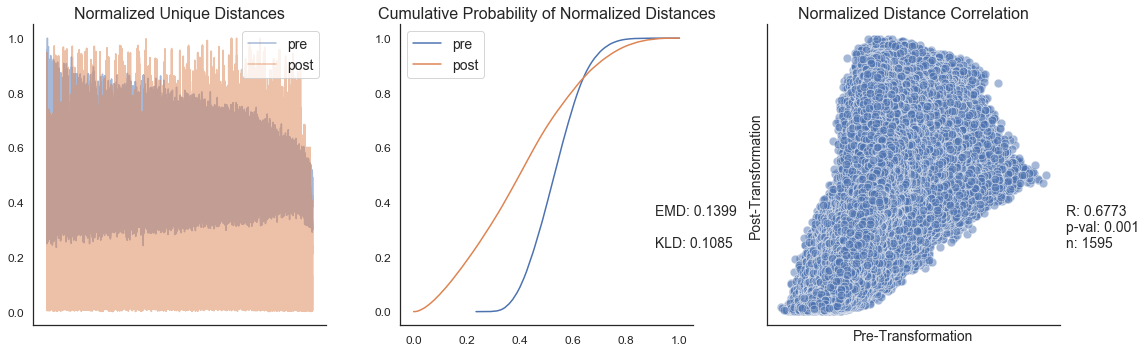

Knn Preservation: 97.905

CPU times: user 1min 25s, sys: 12.4 s, total: 1min 38s
Wall time: 1min 40s


In [42]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_tSNE.knn_graph(k))))

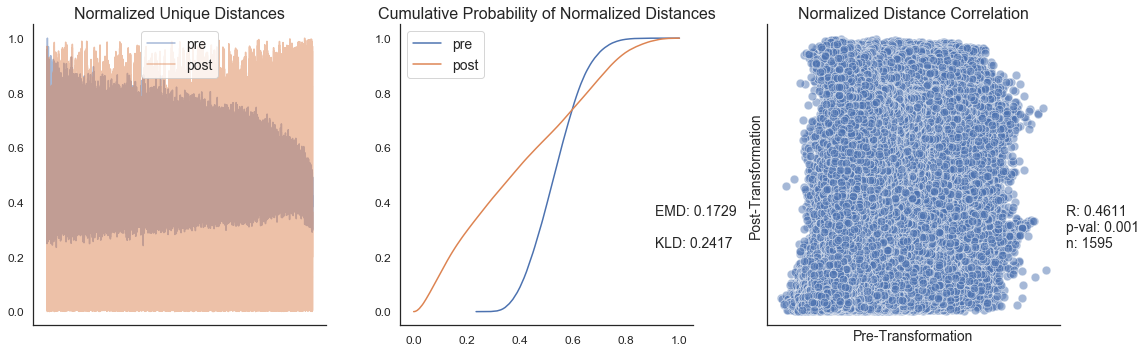

Knn Preservation: 96.8369

CPU times: user 1min 26s, sys: 13.1 s, total: 1min 39s
Wall time: 1min 41s


In [43]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_UMAP.knn_graph(k))))

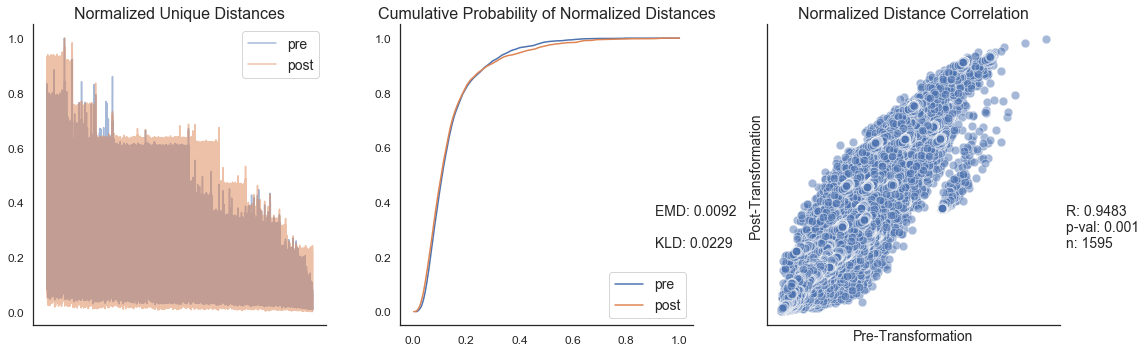

Knn Preservation: 98.1467

CPU times: user 1min 27s, sys: 14.1 s, total: 1min 41s
Wall time: 1min 42s


In [44]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform=None), 
                                  post=qi_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k), 
                                                       post=qi_0_DCA.knn_graph(k))))

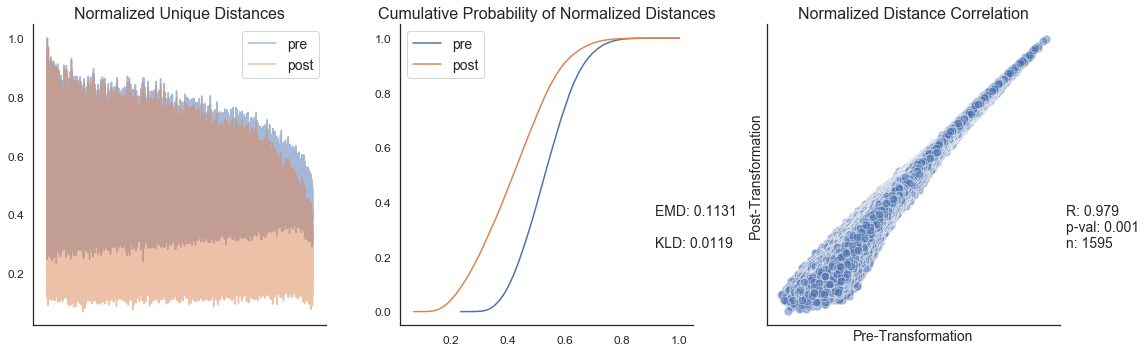

Knn Preservation: 99.5824

CPU times: user 1min 19s, sys: 11.6 s, total: 1min 31s
Wall time: 1min 31s


In [45]:
%%time
# look at 33-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA33.knn_graph(k))))